# 패키지 및 데이터 불러오기

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
# import tqdm

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# seed 설정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
# 소수점 이하 3자리 반올림, 과학적 표기법 해제
pd.set_option('display.float_format', '{:.3f}'.format)
np.set_printoptions(suppress=True, precision=3)

In [5]:
# 파일 경로 설정
file_path = '../data/'

# 파일 불러오기
train_data = pd.read_csv(file_path + 'train.csv').assign(_type = 'train').drop('_type', axis=1)
test_data = pd.read_csv(file_path + 'test.csv').assign(_type = 'test').drop('_type', axis=1)
sample_submission = pd.read_csv(file_path + 'sample_submission.csv')
df = pd.concat([train_data, test_data], axis=0)

subwayInfo = pd.read_csv(file_path + 'subwayInfo.csv')
interestRate = pd.read_csv(file_path + 'interestRate.csv')
schoolInfo = pd.read_csv(file_path + 'schoolinfo.csv')
parkInfo = pd.read_csv(file_path + 'parkInfo.csv')

# 기술통계량

In [34]:
print(f'train shape : {train_data.shape}')
print(f'test shape : {test_data.shape}') # deposit이 빠짐

print(f'subwayInfo shape : {subwayInfo.shape}')
print(f'interestRate shape : {interestRate.shape}')
print(f'schoolInfo shape : {schoolInfo.shape}')
print(f'parkInfo shape : {parkInfo.shape}')

train shape : (1801228, 11)
test shape : (150172, 10)
subwayInfo shape : (700, 2)
interestRate shape : (66, 2)
schoolInfo shape : (11992, 3)
parkInfo shape : (17564, 3)


## train, test

In [14]:
train_data.describe()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
count,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000
mean,900613.500,75.188,202133.126,15.899,1.204,10.052,2004.199,37.477,126.966,17.066,38162.229
std,519969.880,25.526,135.281,8.626,0.885,6.973,11.151,0.163,0.170,11.128,26103.774
min,0.000,10.322,201904.000,1.000,0.000,-4.000,1961.000,36.918,126.479,-3.000,300.000
25%,450306.750,59.750,202008.000,9.000,0.000,5.000,1995.000,37.380,126.842,7.000,21000.000
50%,900613.500,77.150,202111.000,16.000,2.000,9.000,2004.000,37.502,126.998,17.000,32000.000
75%,1350920.250,84.960,202212.000,23.000,2.000,14.000,2015.000,37.582,127.089,26.000,47800.000
max,1801227.000,317.360,202312.000,31.000,2.000,68.000,2024.000,38.182,127.661,62.000,1100000.000


In [21]:
train_data.isnull().sum()

index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
deposit                0
_type                  0
dtype: int64

In [ ]:
test_data.describe()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age
count,150172.000,150172.000,150172.000,150172.000,150172.000,150172.000,150172.000,150172.000,150172.000,150172.000
mean,75085.500,74.510,202403.138,14.817,0.426,10.061,2004.908,37.475,126.968,19.092
std,43351.067,23.971,1.646,8.538,0.597,6.983,11.460,0.167,0.172,11.460
min,0.000,10.780,202401.000,1.000,0.000,-3.000,1966.000,36.957,126.479,0.000
25%,37542.750,59.760,202402.000,7.000,0.000,5.000,1995.000,37.373,126.841,8.000
50%,75085.500,75.794,202403.000,15.000,0.000,9.000,2004.000,37.500,126.999,20.000
75%,112628.250,84.958,202405.000,22.000,1.000,14.000,2016.000,37.589,127.092,29.000
max,150171.000,273.860,202406.000,31.000,2.000,60.000,2024.000,38.106,127.661,58.000


In [ ]:
test_data.isnull().sum()

index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
_type                  0
dtype: int64

In [8]:
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')

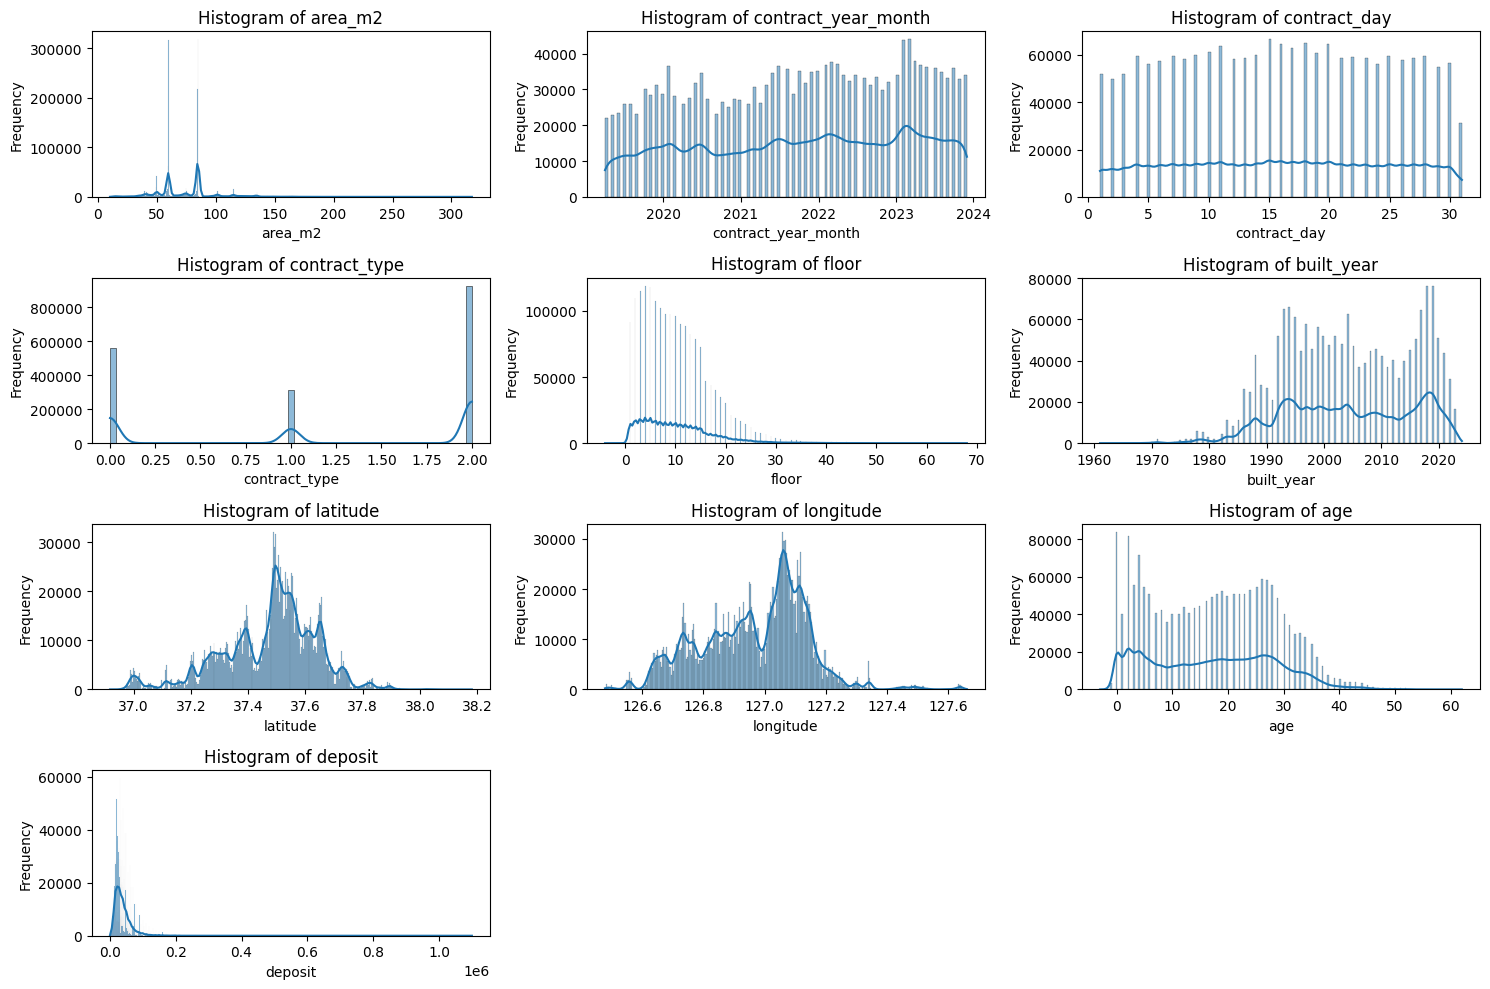

In [9]:
# 서브플롯 설정
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# 각 특성에 대해 히스토그램 그리기
for i, column in enumerate(train_data.drop("index", axis=1).columns):
    sns.histplot(train_data[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# 빈 서브플롯 숨기기 (특성이 11개라 마지막 하나는 빈칸)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## subwayInfo

In [19]:
subwayInfo.describe()

,latitude,longitude
count,700.000,700.000
mean,37.511,126.980
std,0.151,0.182
min,36.770,126.476
25%,37.475,126.880
50%,37.528,127.007
75%,37.580,127.071
max,37.948,127.724


In [23]:
subwayInfo.isnull().sum()

latitude     0
longitude    0
dtype: int64

In [24]:
# Folium 지도 생성 (초기 중심은 세계의 중심으로 설정)
m = folium.Map(location=[37.511, 126.980], zoom_start=11) # tiles=None

# 각 위치에 마커 추가
for idx, row in subwayInfo.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=1,
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# 지도를 HTML 파일로 저장하거나 주피터 노트북에서 직접 표시할 수 있습니다.
m.save('maps/subways.html')
m  # 주피터 노트북에서 직접 표시할 때 사용

## interestRate

In [28]:
interestRate.describe()

,year_month,interest_rate
count,66.000,66.000
mean,202124.500,2.180
std,161.989,1.172
min,201812.000,0.800
25%,202004.250,1.170
50%,202108.500,1.750
75%,202278.750,3.555
max,202405.000,4.340


In [36]:
interestRate.isnull().sum()

year_month       0
interest_rate    0
dtype: int64

In [63]:
interestRate['year_month'] = pd.to_datetime(interestRate['year_month'], format='%Y%m')

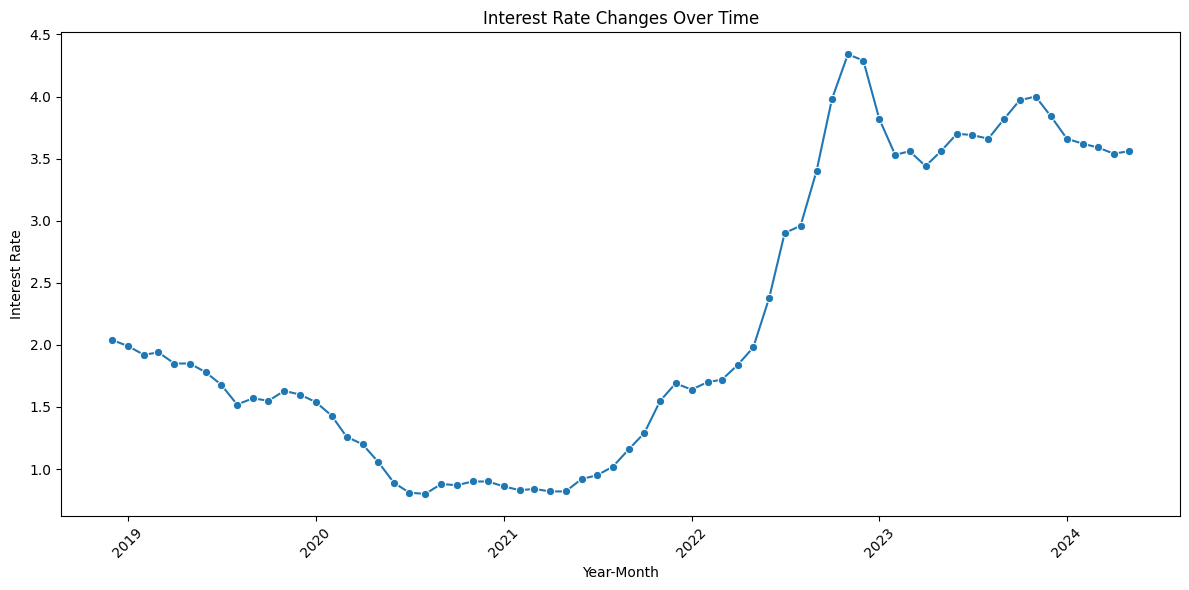

In [64]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
sns.lineplot(data=interestRate, x='year_month', y='interest_rate', marker='o')

# 그래프 꾸미기
plt.xticks(rotation=45)
plt.title('Interest Rate Changes Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Interest Rate')
plt.tight_layout()
plt.show()

## schoolInfo

In [18]:
schoolInfo.describe()

,latitude,longitude
count,11992.000,11992.000
mean,36.442,127.549
std,1.083,0.870
min,33.169,124.662
25%,35.506,126.899
50%,36.593,127.151
75%,37.471,128.339
max,38.542,130.907


In [17]:
schoolInfo["schoolLevel"].unique()

array(['elementary', 'middle', 'high'], dtype=object)

In [38]:
schoolInfo.isnull().sum()

schoolLevel    0
latitude       0
longitude      0
dtype: int64

In [26]:
# 지도 생성 (서울 중심)
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 데이터프레임의 각 위치에 마커와 라벨 추가
for idx, row in schoolInfo.iterrows():
    folium.Circle(
        radius = 5,
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(f"school: {row['schoolLevel']}", parse_html=True)
        # color = "blue"
    ).add_to(m)

# 지도를 HTML 파일로 저장하거나 주피터 노트북에서 직접 표시할 수 있습니다.
m.save('maps/schools.html')
# m  # 주피터 노트북에서 직접 표시할 때 사용

## parkInfo

In [42]:
parkInfo.describe()

,latitude,longitude,area
count,17564.000,17564.000,17564.000
mean,36.537,127.467,31042.725
std,1.026,0.845,202048.664
min,31.373,125.433,0.000
25%,35.772,126.873,1501.225
50%,36.810,127.103,2240.900
75%,37.455,128.068,10263.250
max,38.493,137.203,9320660.000


In [43]:
parkInfo.isnull().sum()

latitude     0
longitude    0
area         0
dtype: int64

In [29]:
# 지도 생성 (서울 중심)
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 데이터프레임의 각 위치에 마커와 라벨 추가
for idx, row in parkInfo.iterrows():
    folium.Circle(
        radius = 50,
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(f"park area: {row['area']}", parse_html=True),
        color = "orange"
    ).add_to(m)

# 지도를 HTML 파일로 저장하거나 주피터 노트북에서 직접 표시할 수 있습니다.
m.save('maps/parks.html')
# m  # 주피터 노트북에서 직접 표시할 때 사용

# 지도 그리기

In [6]:
# Folium 지도 생성 (초기 중심은 세계의 중심으로 설정)
m = folium.Map(location=[37.511, 126.980], zoom_start=11) # tiles=None

# 지하철
for idx, row in subwayInfo.iterrows():
    folium.Circle(
        radius=50,
        location=(row['latitude'], row['longitude']),
        color='blue',
    ).add_to(m)

# 학교
for idx, row in schoolInfo.iterrows():
    folium.Circle(
        radius = 50,
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(f"school: {row['schoolLevel']}", parse_html=True),
        color = "orange"
    ).add_to(m)

# 공원
for idx, row in parkInfo.iterrows():
    folium.Circle(
        radius = 50,
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(f"park area: {row['area']}", parse_html=True),
        color = "green"
    ).add_to(m)

# # train
# # MarkerCluster 추가
# marker_cluster = MarkerCluster().add_to(m)
# # 각 위치에 마커 추가 (클러스터 사용)
# for idx, row in train_data.iterrows():
#     folium.Marker(
#         location=(row['latitude'], row['longitude']),
#         popup=f"{row}"
#     ).add_to(marker_cluster)

# 지도를 HTML 파일로 저장하거나 주피터 노트북에서 직접 표시할 수 있습니다.
m.save('maps/total_map.html')
# m  # 주피터 노트북에서 직접 표시할 때 사용

# 상관관계

In [8]:
df = pd.read_csv(file_path + 'processed_data.csv')

In [9]:
train = df[df['_type'] == 'train'].drop(columns=['_type', 'year_month_date'])
test = df[df['_type'] == 'test'].drop(columns=['_type', 'year_month_date'])

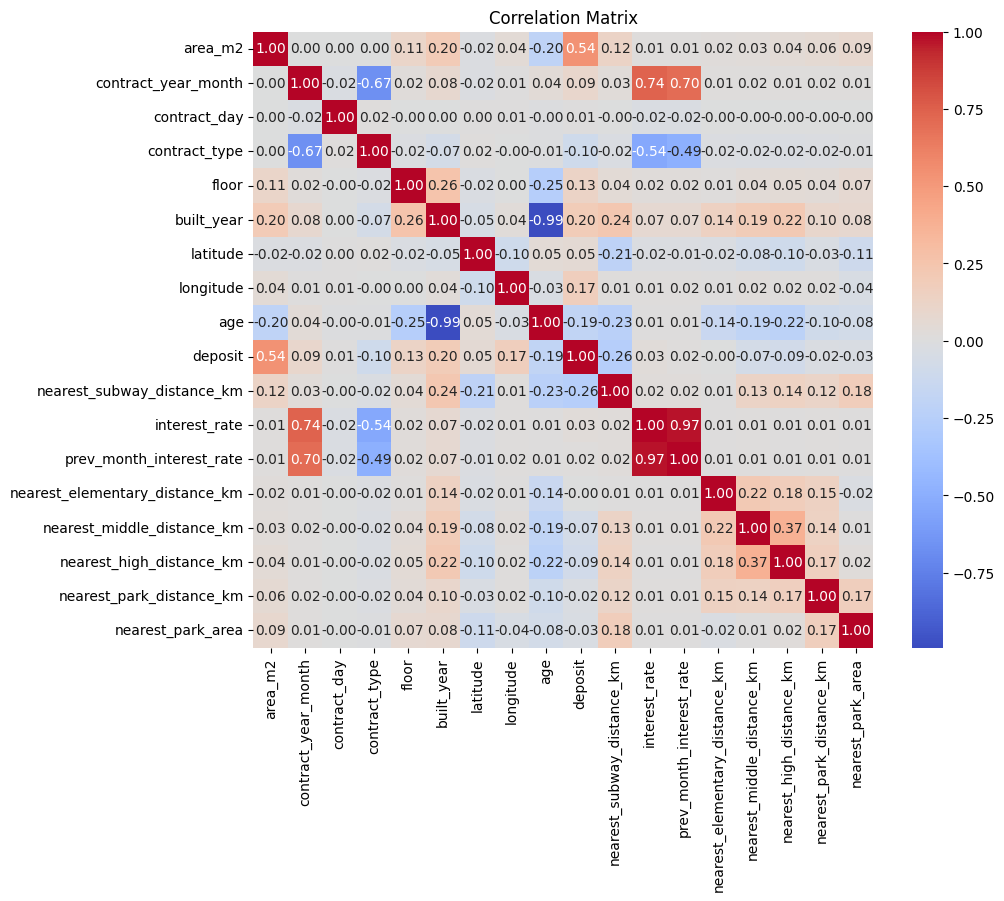

In [41]:
# 상관계수 행렬 계산
corr_matrix = train.drop("index", axis=1).corr('spearman')

# 히트맵으로 상관관계 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

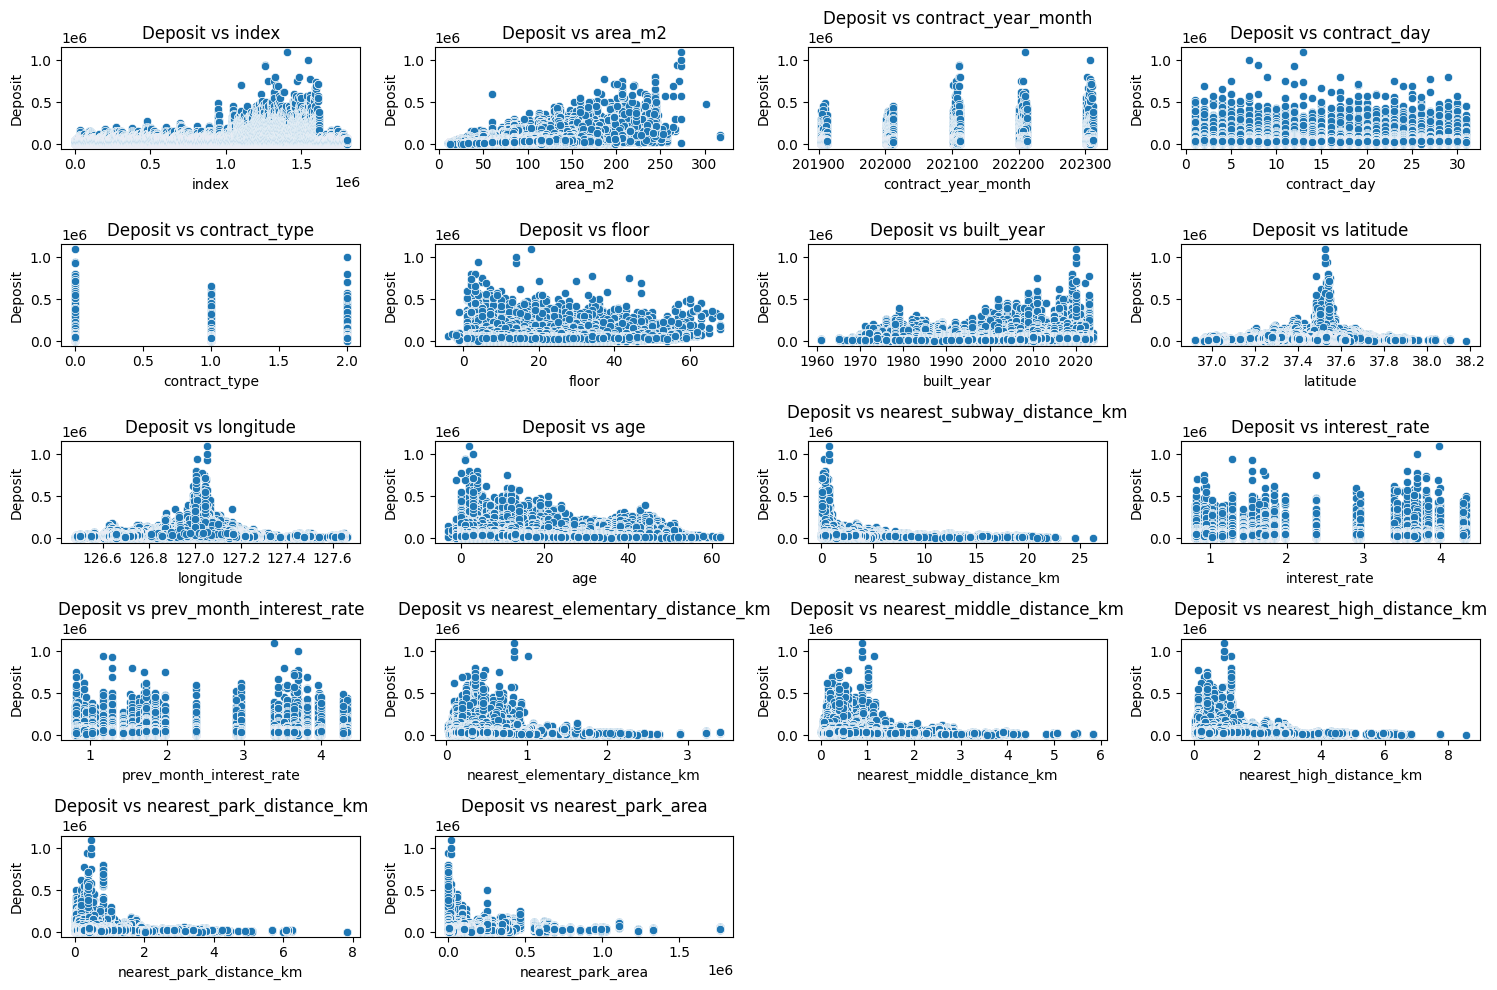

In [10]:
# 변수 리스트 (종속 변수 제외)
variables = [col for col in train.columns if col != 'deposit']

# 산점도 그리기
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(5, 4, i + 1)  # 5행 4열의 서브플롯 설정 (예: 변수 19개)
    sns.scatterplot(x=train[var], y=train['deposit'])
    plt.title(f'Deposit vs {var}')
    plt.xlabel(var)
    plt.ylabel('Deposit')
plt.tight_layout()
plt.show()